In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew   #偏度，用来计算数据集的偏度（表示图像是否对称分布）
from scipy.stats import norm   #正态连续随机变量
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE    #t-distributed Stochastic Neighbor Embedding
from sklearn.decomposition import PCA

<Figure size 432x288 with 0 Axes>

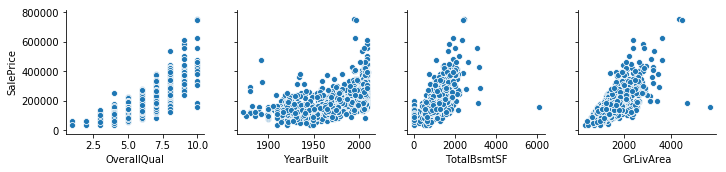

In [2]:
# 对SalePrice有重要影响的4个变量：  OverallQual,YearBuilt,TotalBsmtSF,GrLivArea
train_data = pd.read_csv('data/train.csv')
fugure=plt.figure()
sns.pairplot(x_vars=['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [3]:
# 删除离群的点
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index,inplace=True)
train_data.drop(train_data[(train_data['YearBuilt']<1900) & (train_data['SalePrice']>400000)].index,inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [4]:
# 数据合并
test_data = pd.read_csv('data/test.csv')
my_data = pd.concat([train_data,test_data],axis=0)
my_data.reset_index(drop=True,inplace=True)
train_index=train_data.index
test_index=list(set(my_data.index).difference(set(train_data.index)))

D:\soft\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


In [5]:
# 处理缺失数据
all_data = pd.concat([train_data,test_data])
count = all_data.isnull().sum().sort_values(ascending=False)
ratio=count/len(all_data)
nulldata = pd.concat([count,ratio],axis=1,keys=['count','ratio'])
nulldata.head(10)

D:\soft\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


,count,ratio
PoolQC,2906,0.996913
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
SalePrice,1459,0.500515
FireplaceQu,1420,0.487136
LotFrontage,485,0.166381
GarageFinish,159,0.054545
GarageCond,159,0.054545
GarageQual,159,0.054545


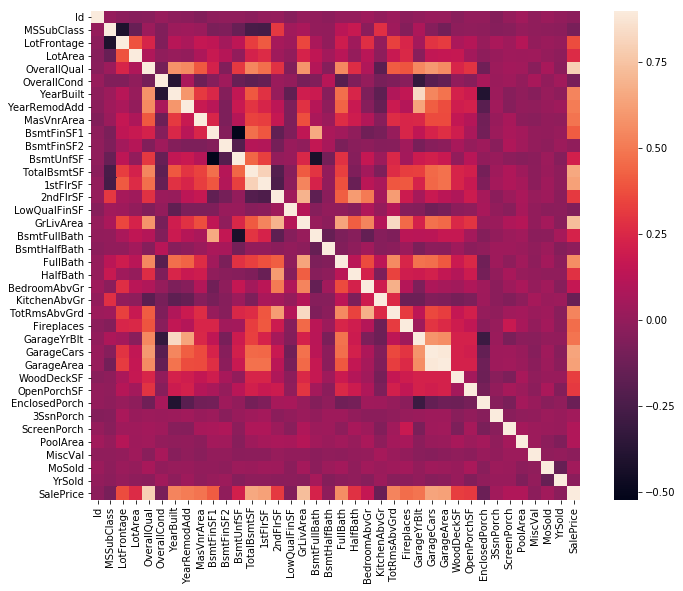

In [6]:
# 观察变量之间的相关性
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)
plt.show()

In [7]:
# 在赛事方提供的特征描述中说明了一部分特征值数据的缺失是由于房屋确实不存在此种类型的特征，
# 因此对于这一部分特征的缺失值，根据特征的数据类型分别进行插补，
# 类别特征的缺失值以一种新类别插补，数值特征以0值插补，剩余的那一部分缺失的特征值采用众数插补。
# 填充缺失值
def fill_missing(res):
    res['Alley'] = res['Alley'].fillna('missing')
    res['PoolQC'] = res['PoolQC'].fillna(res['PoolQC'].mode()[0])
    res['MasVnrType'] = res['MasVnrType'].fillna('None')
    res['BsmtQual'] = res['BsmtQual'].fillna(res['BsmtQual'].mode()[0])
    res['BsmtCond'] = res['BsmtCond'].fillna(res['BsmtCond'].mode()[0])
    res['FireplaceQu'] = res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0])
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna(res['GarageFinish'].mode()[0])
    res['GarageQual'] = res['GarageQual'].fillna(res['GarageQual'].mode()[0])
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    res['Fence'] = res['Fence'].fillna('missing')
    res['Street'] = res['Street'].fillna('missing')
    res['LotShape'] = res['LotShape'].fillna('missing')
    res['LandContour'] = res['LandContour'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0])
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    res['CentralAir'] = res['CentralAir'].fillna('missing')
    res['Electrical'] = res['Electrical'].fillna(res['Electrical'].mode()[0])
    res['MiscFeature'] = res['MiscFeature'].fillna('missing')
    res['MSZoning'] = res['MSZoning'].fillna(res['MSZoning'].mode()[0])    
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res["Functional"] = res["Functional"].fillna("Typ")
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    
    #数值型变量的空值先用0值替换
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    for fl in flist:
        res[fl] = res[fl].fillna(0)
    
    res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    res['GarageArea'] = res['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['GarageCars'] = res['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    res['LotFrontage'] = res['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)  
    
    return res
mydata = fill_missing(my_data)

In [8]:
# 特征工程
# 一些特征被表示为数值特征缺乏意义，例如年份还有类别，将其转化为字符串，即类别性变量
mydata['MSSubClass'] = mydata['MSSubClass'].apply(str)
mydata['YrSold'] = mydata['YrSold'].astype(str)
mydata['MoSold'] = mydata['MoSold'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

In [9]:
# 对顺序特征进行编码
def QualToInt(x):
    if x=='Ex':
        r=0
    elif x=='Gd':
        r=1
    elif x=='TA':
        r=2
    elif x=='Fa':
        r=3
    elif x=='missing':
        r=4
    else:
        r=5
    return r

mydata['ExterQual'] = mydata['ExterQual'].apply(QualToInt)
mydata['ExterCond'] = mydata['ExterCond'].apply(QualToInt)
mydata['KitchenQual'] = mydata['KitchenQual'].apply(QualToInt)
mydata['HeatingQC'] = mydata['HeatingQC'].apply(QualToInt)
mydata['BsmtQual'] = mydata['BsmtQual'].apply(QualToInt)
mydata['BsmtCond'] = mydata['BsmtCond'].apply(QualToInt)
mydata['FireplaceQu'] = mydata['FireplaceQu'].apply(QualToInt)
mydata['GarageQual'] = mydata['GarageQual'].apply(QualToInt)
mydata['PoolQC'] = mydata['PoolQC'].apply(QualToInt)

mydata['BsmtFinType1'] = mydata['BsmtFinType1'].map({'missing':0,'LwQ':1,'BLQ':2,
                                                    'Rec':3,'ALQ':4,'GLQ':5,'Unf':6})

mydata['MasVnrType'] = mydata['MasVnrType'].map({'BrkCmn':1,'None':1,'BrkFace':2,'Stone':3})

mydata['Foundation'] = mydata['Foundation'].map({'Slab':1,'BrkTil':2,'CBlock':2,'Stone':2,
                                                'Wood':3,'PConc':4})

mydata['HouseStyle'] = mydata['HouseStyle'].map({'1.5Unf':1,
                                                 '1.5Fin':2,'2.5Unf':2,'SFoyer':2,
                                                 '1Story':3,'SLvl':3,
                                                 '2Story':4,'2.5Fin':4})

mydata['Functional'] = mydata['Functional'].map({'Maj2':1,'Maj1':2,'Min1':2,'Min2':2,
                                                'Mod':2,'Sev':2,'Typ':3})

mydata['BsmtExposure'] = mydata['BsmtExposure'].map({'None':1,'No':2,'Av':3,'Mn':3,'Gd':4})

mydata['GarageFinish'] = mydata['GarageFinish'].map({'None':1,'Unf':2,'RFn':3,'Fin':4})

mydata['PavedDrive'] = mydata['PavedDrive'].map({'N':1,'P':2,'Y':3})

mydata['Street'] = mydata['Street'].map({'Grvl':1,'Pave':2})


In [10]:
# 增加特征： 总面积 = 地下室面积 + 1楼面积 + 2楼面积
mydata['TotalSF'] = mydata['TotalBsmtSF'] + mydata['1stFlrSF'] + mydata['2ndFlrSF']

# 增加特征：是否存在一些特定的区域空间
mydata['HasWoodDeck'] = (mydata['WoodDeckSF'] == 0) * 1
mydata['HasOpenPorch'] = (mydata['OpenPorchSF'] == 0) * 1
mydata['HasEnclosedPorch'] = (mydata['EnclosedPorch'] == 0) * 1
mydata['Has3SsnPorch'] = (mydata['3SsnPorch'] == 0) * 1
mydata['HasScreenPorch'] = (mydata['ScreenPorch'] == 0) * 1

# 房屋改造时间(YearRemodAdd)与房屋出售时间(YrSold)间隔时间的长短
mydata['YearSinceRemodel'] = mydata['YrSold'].astype(int) - mydata['YearRemodAdd'].astype(int)

# 房屋的整体质量
mydata['Total_Home_Quality'] = mydata['OverallQual'] + mydata['OverallCond']

In [11]:
# # 绘制每个定量变量与目标变量的分布图，准备进行数据转换
# quantitative = [f for f in mydata.columns if mydata.dtypes[f] != 'object' and 
#                mydata.dtypes[f] != 'str']
# quantitative.remove('SalePrice')
# f = pd.melt(mydata,value_vars=quantitative)
# g = sns.FacetGrid(f,col='variable',col_wrap=5,sharex=False,sharey=False)
# g = g.map(sns.distplot,'value')
# plt.show()

In [12]:
# 计算各个定量变量的偏度（skewness）
from scipy.stats import norm,skew
quantitative = [f for f in mydata.columns if mydata.dtypes[f] != 'object' and 
               mydata.dtypes[f] != 'str']
skewed_feats = mydata[quantitative].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(20)

,Skew
PoolQC,31.933352
MiscVal,21.932147
PoolArea,17.682542
LotArea,13.279061
LowQualFinSF,12.407713
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.931624


In [13]:
# 对于偏度大于0.15的变量，可以对其进行log操作以提升质量
def addlogs(res,ls):
    m=res.shape[1]
    for l in ls:
        res=res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l +'_log'
        m += 1
    return res
loglist = skewness[abs(skewness)>0.15].index.tolist()
mydata = addlogs(mydata,loglist)

D:\soft\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log


In [14]:
# OneHotEncoder
# 找出所有需要编码的定性变量，除去已经做了转化的顺序变量
qualitative = [f for f in mydata.columns if mydata.dtypes[f] == 'object' or 
              mydata.dtypes[f] == 'str']
oridnals=['BsmtFinType1','MasVnrType','Foundation','HouseStyle','Functional','BsmtExposure','GarageFinish','PavedDrive','Street',
                   'ExterQual', 'PavedDrive','ExterQua','ExterCond','KitchenQual','HeatingQC','BsmtQual','FireplaceQu','GarageQual','PoolQC']
qualitative = list(set(qualitative).difference(set(oridnals)))


In [15]:
# 对定性变量进行独热编码，并与之前的顺序变量以及已经做了log转换的定量变量合并为一个数据集
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
def getdummies(res,ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = OneHotEncoder()
        le = LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1,1)
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1).toarray()),le,enc
    decoder=[]
    outres = pd.DataFrame({'A':[]})
    
    for l in ls:
        cat,le,enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True,inplace=True)
        outres = pd.concat([outres,cat],axis=1)
        decoder.append([le,enc])
    return (outres,decoder)

In [16]:
catpredlist = qualitative
res = getdummies(mydata[catpredlist],catpredlist)
df = res[0]
decoder = res[1]
floatAndordinal = list(set(mydata.columns.values).difference(set(qualitative)))
mydata.columns.values
print(df.shape)
df = pd.concat([df,mydata[floatAndordinal]],axis=1)
df.drop(['SalePrice'],axis=1,inplace=True)

D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

(2915, 210)


D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

In [17]:
df.shape

(2915, 331)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=295)
df = pd.DataFrame(pca.fit_transform(df))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:
# 建模
df_train = df.iloc[train_index]
df_score = df.iloc[test_index]
my_traindata = mydata.iloc[train_index]
X=np.array(df_train)
X=np.delete(X,0,1)    #删除y轴第0列
y=np.log(1+np.array(my_traindata['SalePrice']))
X.shape

(1456, 330)

In [20]:
# 第一层基模型选择Ridge,Lasso,ElasticNet,lightgbm
# 第二层模型选用Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold,GridSearchCV
nF=20
kf = KFold(n_splits=nF,random_state=23,shuffle=True)

test_errors_l2 = []
train_errors_l2 = []
tret_errors_l1 = []
train_errors_l1 = []
test_errors_GBR = []
train_errors_GBR = []
test_errors_ENet = []
train_errors_ENet = []
test_errors_LGB = []
train_errors_LGB = []
test_errors_ens = []
train_errors_ens = []

models = []

pred_all = []

ifold = 1

for train_index,test_index in kf.split(X):
    print('fold: ',ifold)
    ifold = ifold + 1
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    # ridge
    l2Regr = Ridge(alpha=9.0,fit_intercept=True)
    l2Regr.fit(X_train,y_train)
    pred_train_l2 = l2Regr.predict(X_train)
    pred_test_l2 = l2Regr.predict(X_test)
    
    # lasso
    l1Regr = make_pipeline(RobustScaler(),Lasso(alpha=0.0003,random_state=1,max_iter=50000))
    l1Regr.fit(X_train,y_train)
    pred_train_l1 = l1Regr.predict(X_train)
    pred_test_l12 = l1Regr.predict(X_test)
    
    # GBR
    myGBR = GradientBoostingRegressor(n_estimator=3000,learning_rate=0.02,max_depth=4,
                                      max_features='sqrt',min_samples_leaf=15,min_samples_spllit=50,
                                      loss='huber',random_state=5)
    myGBR.fit(X_train,y_train)
    pred_train_GBR = myGBR.predict(X_train)
    pred_test_GBR = myGBR.predict(X_test)
    
    #ENet
    ENet = make_pipeline(RobustScaler(),ElasticNet(alpha=4.0,l1_ratio=0.005,random_state=3))
    ENet.fit(X_train,y_train)
    pred_train_ENet = ENet.predict(X_train)
    pred_test_ENet = ENet.predict(X_test)
    
    #LGB
    myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05,
                             n_estimators=600,max_bin=50,bagging_fraction=0.6,bagging_freq=5,
                              feature_fraction=0.25,feature_fraction_seed=9,bagging_seed=9,
                              min_data_in_leaf=6,min_sum_hessian_in_leaf=11)
    myLGB.fit(X_train,y_train)
    pred_train_LGB = myLGB.predict(X_train)
    pred_test_LGB = myLGB.predict(X_test)
    
    #stacking
    stackedset = pd.DataFrame({'A':[]})
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l2)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l1)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_GBR)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ENet)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_LGB)],axis=1)
    
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack,0,axis=1)
    l1_stacked = Lasso(alpha=0.0001,fit_interept=True)
    l1_stacked.fit(Xstack,y_test)
    pred_test_stack = l1_stacked.predict(Xstack)
    models.append([l2Regr,l1Regr,myGBR,ENet,myLGB,l1_stacked])
    

fold:  1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').